In [1]:
!pip install tensorflow
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/content/CIC-DOS-2017.csv')

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['Label'].value_counts()}")

# Map 'Benign' to 0 and everything else to 1
df['Label'] = np.where(df['Label'] == 'Benign', 0, 1)

# Define features and target
features = [col for col in df.columns if col != 'Label']
target = 'Label'

print(f"Total features before processing: {len(features)}")
print(f"Dataset columns: {list(df.columns)}")

# STEP 1: Identify numerical and categorical columns
print("\n" + "="*60)
print("STEP 1: IDENTIFYING COLUMN TYPES")
print("="*60)

# # Replace positive infinity with the column's mean
# for col in df.columns:
#     if df[col].dtype == np.number: # Check if column is numeric
#         mean_val = df[col][np.isfinite(df[col])].mean() # Calculate mean excluding infinities
#         df[col].replace(np.inf, mean_val, inplace=True)

# # Replace negative infinity with the column's mean (or a very small number)
# for col in df.columns:
#     if df[col].dtype == np.number:
#         mean_val = df[col][np.isfinite(df[col])].mean()
#         df[col].replace(-np.inf, mean_val, inplace=True)

# Separate numerical and categorical data from feature columns only
num_cols = df[features].select_dtypes(include=['number']).columns.tolist()
cat_cols = df[features].select_dtypes(exclude=['number']).columns.tolist()

print(f"Numerical columns ({len(num_cols)}): {num_cols[:5]}...")  # Show first 5
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# STEP 2: Handle missing values BEFORE scaling/encoding
print("\n" + "="*60)
print("STEP 2: HANDLING MISSING VALUES")
print("="*60)

# Handle missing values in numerical columns
missing_num_info = []
for col in num_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_num_info.append(f"{col}: {missing_count} missing values")
        df[col] = df[col].fillna(df[col].mean())

if missing_num_info:
    print("Missing values in numerical columns (filled with mean):")
    for info in missing_num_info:
        print(f"  - {info}")
else:
    print("No missing values in numerical columns")

# Handle missing values in categorical columns
missing_cat_info = []
for col in cat_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        missing_cat_info.append(f"{col}: {missing_count} missing values (filled with '{mode_val}')")
        df[col] = df[col].fillna(mode_val)

if missing_cat_info:
    print("Missing values in categorical columns:")
    for info in missing_cat_info:
        print(f"  - {info}")
else:
    print("No missing values in categorical columns")

# STEP 3: Scale numerical columns
print("\n" + "="*60)
print("STEP 3: SCALING NUMERICAL COLUMNS")
print("="*60)

if num_cols:
    print(f"Scaling {len(num_cols)} numerical columns...")

    # Show statistics before scaling (first 5 columns)
    print("Statistics before scaling (first 5 numerical columns):")
    for col in num_cols[:5]:
        mean_val = df[col].mean()
        std_val = df[col].std()
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"  {col}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val:.3f}, max={max_val:.3f}")

    # Apply StandardScaler
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

    # Show statistics after scaling
    print("Statistics after scaling (first 5 numerical columns):")
    for col in num_cols[:5]:
        mean_val = df_scaled[col].mean()
        std_val = df_scaled[col].std()
        min_val = df_scaled[col].min()
        max_val = df_scaled[col].max()
        print(f"  {col}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val:.3f}, max={max_val:.3f}")

    df = df_scaled
    print("✓ Numerical columns scaled successfully")
else:
    print("No numerical columns to scale")

# STEP 4: Encode categorical columns
print("\n" + "="*60)
print("STEP 4: ENCODING CATEGORICAL COLUMNS")
print("="*60)

if cat_cols:
    print(f"Processing {len(cat_cols)} categorical columns...")

    # Analyze cardinality of categorical columns
    high_cardinality_cols = []
    low_cardinality_cols = []

    for col in cat_cols:
        unique_count = df[col].nunique()
        print(f"  {col}: {unique_count} unique values")

        if unique_count > 50:  # Threshold for high cardinality
            high_cardinality_cols.append(col)
        else:
            low_cardinality_cols.append(col)

    print(f"\nHigh cardinality columns (>50 unique values): {high_cardinality_cols}")
    print(f"Low cardinality columns (≤50 unique values): {low_cardinality_cols}")

    # Apply Label Encoding to high cardinality columns
    if high_cardinality_cols:
        print(f"\nApplying Label Encoding to {len(high_cardinality_cols)} high cardinality columns...")
        label_encoders = {}

        for col in high_cardinality_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            print(f"  ✓ {col}: encoded to values 0-{df[col].max()}")

    # Apply One-Hot Encoding to low cardinality columns
    if low_cardinality_cols:
        print(f"\nApplying One-Hot Encoding to {len(low_cardinality_cols)} low cardinality columns...")

        # Ensure columns still exist in the DataFrame
        low_cardinality_cols = [col for col in low_cardinality_cols if col in df.columns]
        if not low_cardinality_cols:
            print("  Warning: No low cardinality columns found in DataFrame at this stage.")
        else:
            # Get dummy variables
            df_dummies = pd.get_dummies(df[low_cardinality_cols], drop_first=True)
            print(f"  Created {len(df_dummies.columns)} dummy variables")

            # Drop original categorical columns and add dummy variables
            df = df.drop(columns=low_cardinality_cols)
            df = pd.concat([df, df_dummies], axis=1)

            print("  ✓ One-hot encoding completed")
            print(f"  New dummy columns: {list(df_dummies.columns)[:5]}...")  # Show first 5


# STEP 5: Finalize processed dataset
print("\n" + "="*60)
print("STEP 5: FINALIZING PROCESSED DATASET")
print("="*60)

# Update features list after all transformations
df_processed = df.copy()
features = [col for col in df_processed.columns if col != target]

print(f"Final number of features: {len(features)}")
print(f"Final dataset shape: {df_processed.shape}")

# Ensure all feature columns are numeric
non_numeric_features = []
for col in features:
    if not pd.api.types.is_numeric_dtype(df_processed[col]):
        non_numeric_features.append(col)
        # Convert to numeric, coercing errors to NaN
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        # Fill any NaNs that might have been introduced
        if df_processed[col].isnull().any():
            df_processed[col] = df_processed[col].fillna(df_processed[col].mean())

if non_numeric_features:
    print(f"Warning: Had to convert {len(non_numeric_features)} columns to numeric: {non_numeric_features}")
else:
    print("✓ All feature columns are numeric")

# Verify data types
print("\nFinal data types:")
print(f"  Numerical features: {len([col for col in features if pd.api.types.is_numeric_dtype(df_processed[col])])}")
print(f"  Target column: {df_processed[target].dtype}")

print("✓ Data preprocessing completed successfully!")

# STEP 6: Remove duplicates
print("\n" + "="*60)
print("STEP 6: REMOVING DUPLICATES")
print("="*60)

initial_shape = df_processed.shape[0]
df_processed = df_processed.drop_duplicates()
removed_duplicates = initial_shape - df_processed.shape[0]
print(f"Removed {removed_duplicates} duplicate rows ({removed_duplicates/initial_shape*100:.1f}% of data)")
print(f"Final dataset shape after duplicate removal: {df_processed.shape}")

# STEP 7: Handle outliers using IQR method
print("\n" + "="*60)
print("STEP 7: HANDLING OUTLIERS")
print("="*60)

def handle_outliers_iqr(df_in, col_name):
    """Handle outliers using Interquartile Range (IQR) method"""
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers before handling
    outliers_count = ((df_in[col_name] < lower) | (df_in[col_name] > upper)).sum()

    df_out = df_in.copy()
    df_out.loc[df_out[col_name] < lower, col_name] = lower
    df_out.loc[df_out[col_name] > upper, col_name] = upper

    return df_out, outliers_count

print("Handling outliers for numerical features...")
clean_df = df_processed.copy()
total_outliers = 0

# Only apply outlier handling to truly numerical features
numerical_features = [col for col in features if col in num_cols or
                     (col not in num_cols and not any(col.startswith(f"{cat_col}_") for cat_col in cat_cols if cat_cols))]

print(f"Applying outlier handling to {len(numerical_features)} numerical features...")

for col in numerical_features[:10]:  # Limit to first 10 to avoid too much output
    if col in clean_df.columns:
        clean_df, outliers_count = handle_outliers_iqr(clean_df, col)
        if outliers_count > 0:
            total_outliers += outliers_count
            print(f"  {col}: {outliers_count} outliers handled")

if total_outliers > 0:
    print(f"✓ Total outliers handled: {total_outliers}")
else:
    print("✓ No significant outliers found")
print("Data preprocessing completed!")

Dataset shape: (222914, 78)
Target distribution:
Label
Benign         208800
ddossim          5115
slowread         2786
slowloris        1858
slowheaders      1651
hulk              747
rudy              703
goldeneye         633
slowbody2         621
Name: count, dtype: int64
Total features before processing: 77
Dataset columns: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Head

Training set shape: (177738, 77)
Test set shape: (44435, 77)
Number of classes: 2
Class labels: [0 1]

Generating Correlation Matrix...
Selected 15 features for correlation matrix


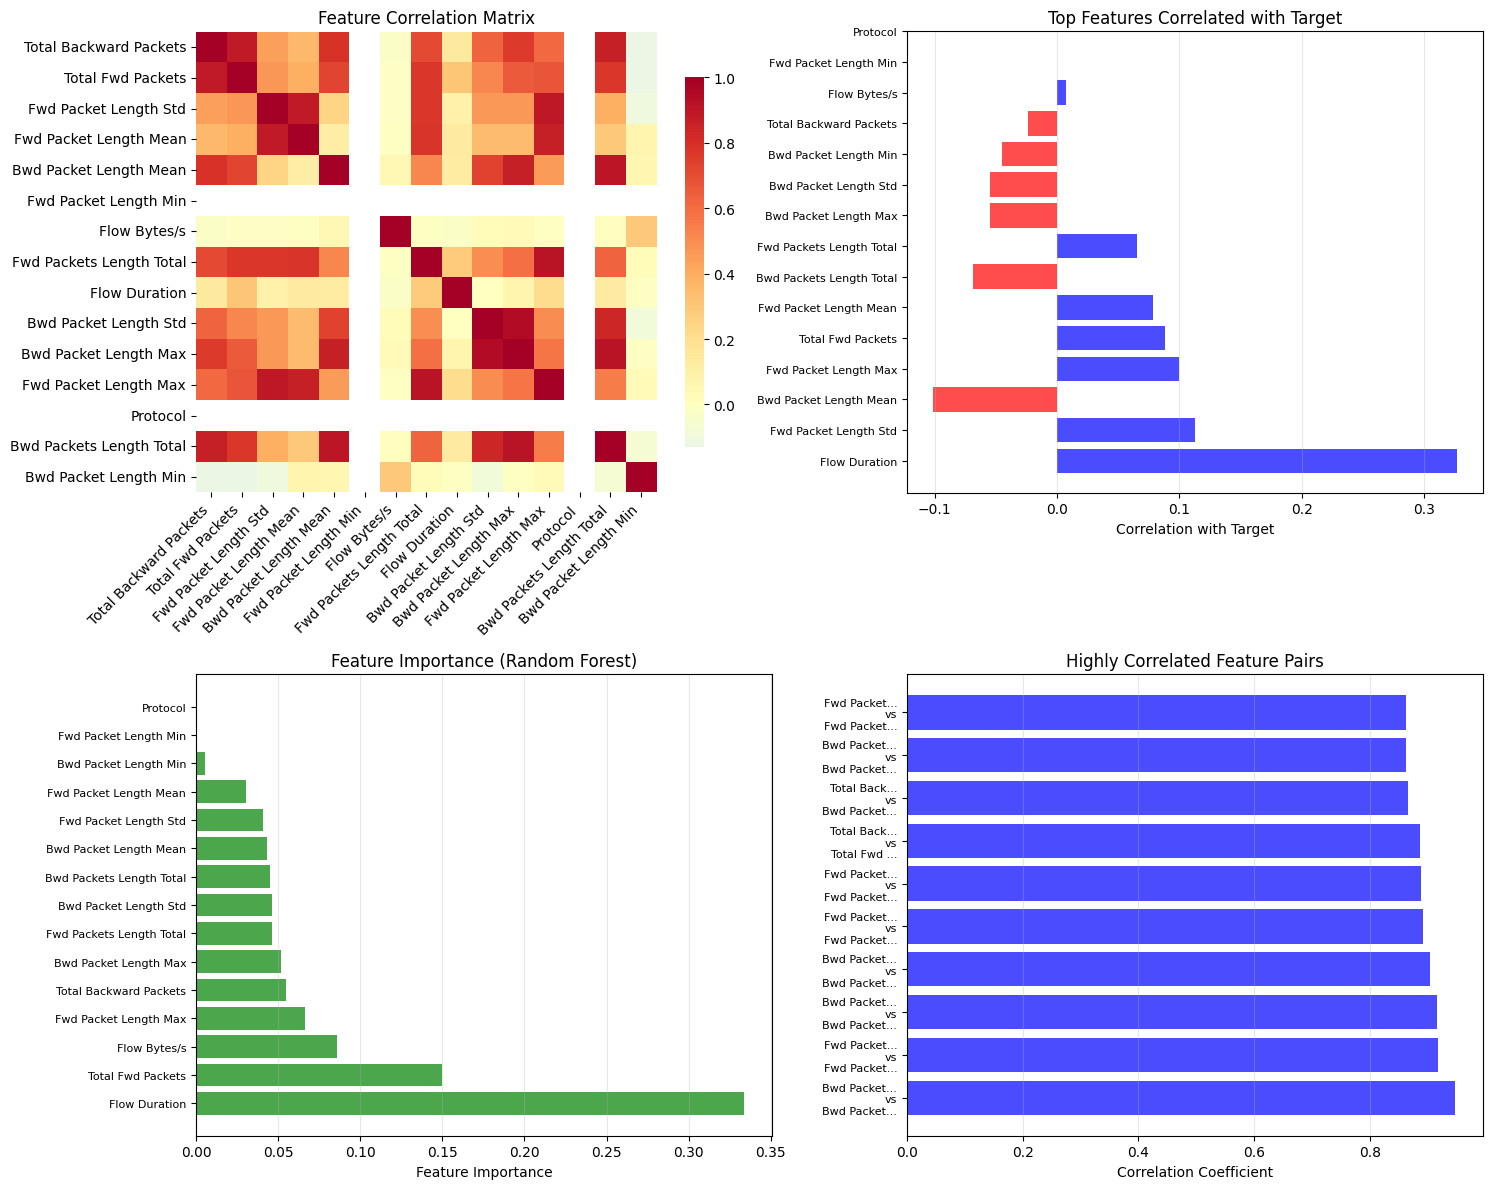

In [4]:
X = clean_df[features]
y = clean_df[target]

# Encode target labels to integers
le_target = LabelEncoder()
y = le_target.fit_transform(y)
n_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class labels: {le_target.classes_}")

# Correlation Matrix Visualization
print("\nGenerating Correlation Matrix...")
plt.figure(figsize=(15, 12))

# Select a subset of features for correlation matrix (to avoid overcrowding)
# We'll use numerical features and some important categorical features
correlation_features = []

# Add numerical features
correlation_features.extend(num_cols[:15])  # First 15 numerical features

# Add some high cardinality encoded features
# if high_cardinality_cols:
#     correlation_features.extend([col for col in high_cardinality_cols if col in X_train.columns][:5])

# Add some low cardinality encoded features
low_card_encoded = [col for col in X_train.columns]
correlation_features.extend(low_card_encoded[:10])

# Remove duplicates and ensure features exist
correlation_features = list(set(correlation_features))
correlation_features = [f for f in correlation_features if f in X_train.columns]

# Limit to prevent overcrowding
correlation_features = correlation_features[:25]

print(f"Selected {len(correlation_features)} features for correlation matrix")

# Create correlation matrix
corr_data = X_train[correlation_features].copy()
correlation_matrix = corr_data.corr()

# Plot correlation matrix
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix,
            annot=False,
            cmap='RdYlBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Plot correlation with target variable
plt.subplot(2, 2, 2)
# Add target to training data temporarily for correlation
temp_data = X_train[correlation_features].copy()
temp_data['Target'] = y_train
target_corr = temp_data.corr()['Target'].drop('Target').sort_values(key=abs, ascending=False)

# Plot top correlations with target
top_corr = target_corr.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), [f.replace('_', '\n') for f in top_corr.index], fontsize=8)
plt.xlabel('Correlation with Target')
plt.title('Top Features Correlated with Target')
plt.grid(axis='x', alpha=0.3)

# Plot feature importance (if we have numerical features)
plt.subplot(2, 2, 3)
if len(num_cols) > 0:
    # Quick Random Forest for feature importance
    rf_temp = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_temp.fit(X_train[correlation_features], y_train)
    feature_importance = pd.Series(rf_temp.feature_importances_, index=correlation_features).sort_values(ascending=False)

    top_importance = feature_importance.head(15)
    plt.barh(range(len(top_importance)), top_importance.values, color='green', alpha=0.7)
    plt.yticks(range(len(top_importance)), [f.replace('_', '\n') for f in top_importance.index], fontsize=8)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No numerical features\nfor importance plot',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Feature Importance')

# Plot highly correlated feature pairs
plt.subplot(2, 2, 4)
# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

if high_corr_pairs:
    # Sort by absolute correlation value
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    high_corr_pairs = high_corr_pairs[:10]  # Top 10 pairs

    pair_names = [f"{pair[0][:10]}...\nvs\n{pair[1][:10]}..." for pair in high_corr_pairs]
    corr_values = [pair[2] for pair in high_corr_pairs]
    colors = ['red' if x < 0 else 'blue' for x in corr_values]

    plt.barh(range(len(corr_values)), corr_values, color=colors, alpha=0.7)
    plt.yticks(range(len(pair_names)), pair_names, fontsize=8)
    plt.xlabel('Correlation Coefficient')
    plt.title('Highly Correlated Feature Pairs')
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No highly correlated\nfeature pairs found\n(threshold: 0.7)',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.title('High Correlation Pairs')

plt.tight_layout()
plt.show()

In [5]:
def split_data(x, y, num_clients):
    # Ensure inputs are DataFrame/Series
    if isinstance(x, np.ndarray):
        x = pd.DataFrame(x)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    client_data = []
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    split_size = len(x) // num_clients

    for i in range(num_clients):
        start = i * split_size
        end = start + split_size if i != num_clients - 1 else len(x)
        client_x = x.iloc[indices[start:end]]
        client_y = y.iloc[indices[start:end]]
        client_data.append((client_x, client_y))

    return client_data

# Usage
num_clients = 5
client_data = split_data(X_train, y_train, num_clients)

# Check sizes and class balance
for i, (cx, cy) in enumerate(client_data):
    print(f"Client {i}: X shape={cx.shape}, Class 0={np.sum(cy==0)}, Class 1={np.sum(cy==1)}, Attack Rate={cy.mean():.3f}")

Client 0: X shape=(35547, 77), Class 0=33321, Class 1=2226, Attack Rate=0.063
Client 1: X shape=(35547, 77), Class 0=33366, Class 1=2181, Attack Rate=0.061
Client 2: X shape=(35547, 77), Class 0=33335, Class 1=2212, Attack Rate=0.062
Client 3: X shape=(35547, 77), Class 0=33303, Class 1=2244, Attack Rate=0.063
Client 4: X shape=(35550, 77), Class 0=33395, Class 1=2155, Attack Rate=0.061


In [6]:
# Define model with proper regularization
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_client_model(model, X_client, y_client, epochs=5):
    history = model.fit(
        X_client, y_client,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    return model.get_weights(), history

def aggregate_weights(client_weights):
    """Average the weights from all clients"""
    averaged_weights = []
    for weights_list_tuple in zip(*client_weights):
        averaged_weights.append(np.mean(np.array(weights_list_tuple), axis=0))
    return averaged_weights

In [12]:
# Federated Learning Loop
global_model = create_model(X_train.shape[1])
global_weights = global_model.get_weights()

num_rounds = 5
num_epochs = 1

print("\nStarting Federated Learning...")
training_history = {'round': [], 'loss': [], 'accuracy': []}

for round_num in range(num_rounds):
    print(f"\nRound {round_num + 1}/{num_rounds}")
    client_weights = []

    for i, (X_client, y_client) in enumerate(client_data):
        # Create fresh model for each client
        client_model = create_model(X_train.shape[1])
        client_model.set_weights(global_weights)

        # Train client model
        client_weight, history = train_client_model(
            client_model, X_client, y_client, epochs=num_epochs
        )
        client_weights.append(client_weight)

        print(f"  Client {i+1} trained - Final accuracy: {history.history['accuracy'][-1]:.4f}")

    # Aggregate weights
    global_weights = aggregate_weights(client_weights)
    global_model.set_weights(global_weights)

    # Evaluate on test data
    loss, accuracy = global_model.evaluate(X_test, y_test, verbose=0)
    training_history['round'].append(round_num + 1)
    training_history['loss'].append(loss)
    training_history['accuracy'].append(accuracy)

    print(f"Global Model - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Starting Federated Learning...

Round 1/5
  Client 1 trained - Final accuracy: 0.9514
  Client 2 trained - Final accuracy: 0.9539
  Client 3 trained - Final accuracy: 0.9524
  Client 4 trained - Final accuracy: 0.9554
  Client 5 trained - Final accuracy: 0.9545
Global Model - Test Loss: 0.0627, Test Accuracy: 0.9801

Round 2/5
  Client 1 trained - Final accuracy: 0.9801
  Client 2 trained - Final accuracy: 0.9789
  Client 3 trained - Final accuracy: 0.9809
  Client 4 trained - Final accuracy: 0.9813
  Client 5 trained - Final accuracy: 0.9809
Global Model - Test Loss: 0.0442, Test Accuracy: 0.9878

Round 3/5
  Client 1 trained - Final accuracy: 0.9849
  Client 2 trained - Final accuracy: 0.9850
  Client 3 trained - Final accuracy: 0.9858
  Client 4 trained - Final accuracy: 0.9867
  Client 5 trained - Final accuracy: 0.9860
Global Model - Test Loss: 0.0358, Test Accuracy: 0.9909

Round 4/5
  Client 1 trained - Final accuracy: 0.9886
  Client 2 trained - Final accuracy: 0.9874
  Client


FINAL EVALUATION
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Final Test Accuracy: 0.9934
Final Test Accuracy (%): 99.34%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     41681
      Attack       0.97      0.92      0.95      2754

    accuracy                           0.99     44435
   macro avg       0.98      0.96      0.97     44435
weighted avg       0.99      0.99      0.99     44435



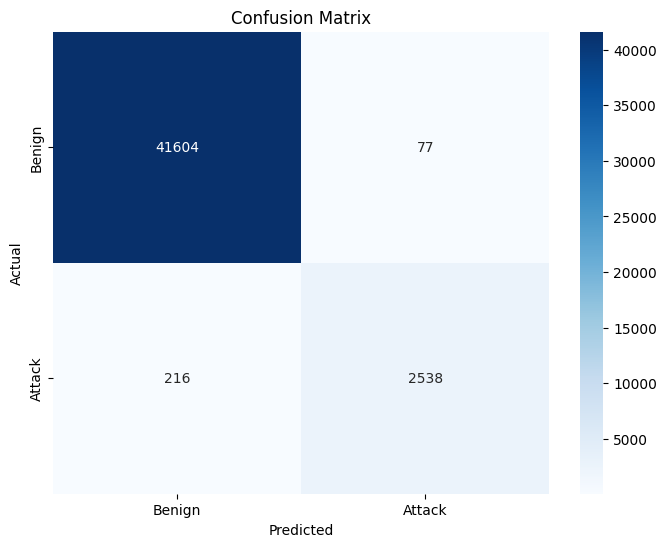

In [13]:
# Final evaluation
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Predict on test set
y_pred_probs = global_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test Accuracy (%): {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

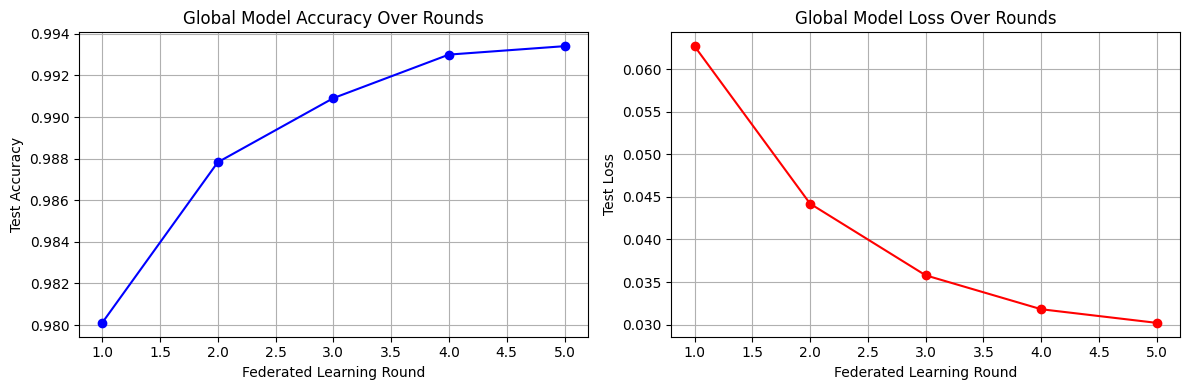

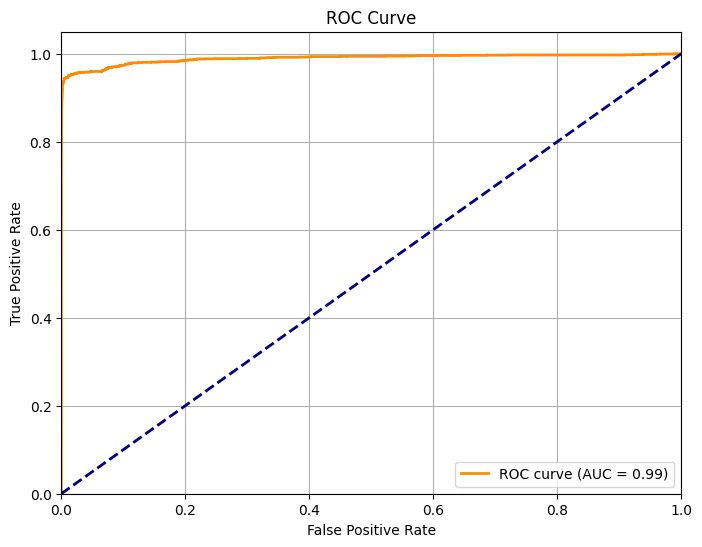


Final Results Summary:
- Test Accuracy: 0.9934 (99.34%)
- AUC Score: 0.9895
- Number of FL Rounds: 5
- Number of Clients: 5


In [14]:
# Training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history['round'], training_history['accuracy'], 'b-o')
plt.title('Global Model Accuracy Over Rounds')
plt.xlabel('Federated Learning Round')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_history['round'], training_history['loss'], 'r-o')
plt.title('Global Model Loss Over Rounds')
plt.xlabel('Federated Learning Round')
plt.ylabel('Test Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"\nFinal Results Summary:")
print(f"- Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"- AUC Score: {roc_auc:.4f}")
print(f"- Number of FL Rounds: {num_rounds}")
print(f"- Number of Clients: {num_clients}")